In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parse_params(param_file):
    params = pd.read_csv(param_file, delimiter=' ', dtype=str, index_col=0, header=None, skiprows=1)
    params.columns = ['k11', 'k12', 'k13', 'k21', 'k22', 'k23', 
                      'k31', 'k32', 'k33', 'r11', 'r12', 'r13', 
                      'r21', 'r22', 'r23', 'r31', 'r32', 'r33', 
                      't1', 't2', 't3']
    params.index.name = 'image name'
    return params

In [3]:
def get_matrices(params, num):
    K = params.iloc[num,0:9].values.reshape(3,3).astype(float)
    R = params.iloc[num,9:18].values.reshape(3,3).astype(float)
    t = params.iloc[num,18:].values.reshape(3,1).astype(float)
    return K, R, t

In [4]:
# read images and params
img0 = cv2.imread('sample data/dino0001.png', 0)
rgb0 = cv2.imread('sample data/dino0001.png')
img1 = cv2.imread('sample data/dino0002.png', 0)
rgb1 = cv2.imread('sample data/dino0002.png')

params = parse_params("sample data/dino_par.txt")
K0, R0, t0 = get_matrices(params, 0)
K1, R1, t1 = get_matrices(params, 1)
f = K0[0,0]

In [5]:
# get matches
def get_matches(imgL, imgR, descriptor='sift'):
    if descriptor=='surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif descriptor=='sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    else:
        raise ValueError
        
    kpL, descL = descriptor.detectAndCompute(imgL, None)
    kpR, descR = descriptor.detectAndCompute(imgR, None)
    imgL_keypoints = cv2.drawKeypoints(imgL, kpL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    imgR_keypoints = cv2.drawKeypoints(imgR, kpR, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descL, descR, k=2) 
    
    good_matches = []
    good_matches_without_list = []
    # ratio test
    for m,n in matches:
        if m.distance < 0.75*n.distance: # only accept matchs that are considerably better than the 2nd best match
            good_matches.append([m])
            good_matches_without_list.append(m) # this is to simplify finding a homography later

    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good_matches_without_list ])
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good_matches_without_list ])
    
    # flip it such that pts = [y,x] = [height,width]
    src_pts = np.array([[y,x] for (x,y) in src_pts])
    dst_pts = np.array([[y,x] for (x,y) in dst_pts])
    return src_pts, dst_pts

In [6]:
# get correspondence points
img0_pts, img1_pts = get_matches(img0, img1)

In [7]:
def normalize_coordinates(img_pts):
    n = len(img_pts)
    # compute centroid in image
    centroid_y, centroid_x = img_pts.mean(0)
    O = np.array([[1, 0, -centroid_y],
                  [0, 1, -centroid_x],
                  [0, 0, 1]])
    
    # recenter
    recentered_pts = img_pts - [centroid_y,centroid_x]
    
    # find scale term
    s = np.sqrt(2) / np.sqrt(1/n * np.sum(recentered_pts**2))
    S = np.array([[s, 0, 0],
                  [0, s, 0],
                  [0, 0, 1]])

    # transformation matrix
    T = S @ O
    
    # new coordinates
    norm_pts = np.empty(img_pts.shape)
    for idx, pt in enumerate(img_pts):
        norm_pt = T @ np.array([[pt[0]], [pt[1]], [1]])
        norm_pt = (norm_pt[:2]).squeeze()
        norm_pts[idx] = norm_pt
    return T, norm_pts #return T s.t. we can convert back later

In [8]:
# def normalize_coordinates(img_pts, height, width):
#     # Normalize: create new coordinate system 
#     # 1) Offset: origin of new coordinate system centered at center of image (not top left)
#     # 2) Scale: coordinate uniformly scaled such that mean distance from origin to point is sqrt(2)
#     O = np.array([[1, 0, -width/2],
#                   [0, 1, -height/2],
#                   [0, 0, 1]])

#     mean_dist = np.sqrt((height/2)**2 + (width/2)**2)
#     S = np.array([[np.sqrt(2)/mean_dist, 0, 0],
#                   [0, np.sqrt(2)/mean_dist, 0],
#                   [0, 0, 1]])

#     # Normalization matrix
#     T = S @ O
    
#     norm_pts = np.empty(img_pts.shape)
#     for idx, pt in enumerate(img_pts):
#         norm_pt = T @ np.array([[pt[0]], [pt[1]], [1]])
#         norm_pt = (norm_pt[:2]).squeeze()
#         norm_pts[idx] = norm_pt
    
#     return T, norm_pts #return T s.t. we can convert back later

In [8]:
T0, img0_pts_norm = normalize_coordinates(img0_pts)
T1, img1_pts_norm = normalize_coordinates(img1_pts)

In [9]:
def eight_point(src_pts, dst_pts, T0, T1):
    # 8-point algorithm
    num_match = src_pts.shape[0]
    A = np.empty((num_match, 9))
    for idx in range(num_match):
        y0, x0 = src_pts[idx]
        y1, x1 = dst_pts[idx]
        A[idx] = [y1*y0, y1*x0, y1, x1*y0, x1*x0, x1, y0, x0, 1]

    # use SVD to solve F -- take column of V corresponding to least singular value
#     U,S,V = np.linalg.svd(A.T@A)
    U,S,VT = np.linalg.svd(A)
    V = VT.T
    F = V[:,-1].reshape(3,3)

    # enforce rank 2 constraint (Tsai and Huang) -- make last eigval 0
    U,S,VT = np.linalg.svd(F)
    S[-1] = 0
    F = U@(np.diag(S))@VT

    # need to un-normalize F
    F = T1.T @ F @ T0
    return F/F[2,2]

In [10]:
F = eight_point(img0_pts_norm, img1_pts_norm, T0, T1)

In [31]:
# get epipoles
U,S,V = np.linalg.svd(F)
idx = np.argmin(S)
e0 = V[idx]
e0 = e0/e0[2]
e1 = U[:,idx]
e1 = e1/e1[2]

In [11]:
# get epipolar lines
def get_epipolar_lines(pts, F, image_num=0):
    """
    Calculates the epipolar lines
    Param:
        image_num: which image we are calculating for. If 0 --> left epiline, if 1 --> right epiline
    Returns:
        epipolar_lines: array of epipolar line coefficients [a,b,c] where 0=ax+by+cz
    """
    
    epipolar_lines = []
    for pt in pts:
        pt_y, pt_x = pt
        pt_arr = np.array([[pt_y],[pt_x],[1]])
        epipolar_line = F@pt_arr if image_num==1 else F.T@pt_arr
        a,b,c = epipolar_line
        # normalize such that a^2 + b^2 = 1
        k = 1/np.sqrt(a**2+b**2)
        a, b = k*a, k*b
        epipolar_lines.append([a,b,c])
    return np.array(epipolar_lines).squeeze()

In [12]:
epipolar_lines = get_epipolar_lines(img1_pts, F, image_num=0)

In [15]:
F_test, mask = cv2.findFundamentalMat(img0_pts,img1_pts,cv2.FM_LMEDS)

In [16]:
F_test

array([[-8.88016715e-07, -1.76289293e-05, -1.32807313e-02],
       [ 2.76291464e-05,  3.25044563e-06,  2.04194843e-01],
       [ 1.10202150e-02, -2.08558913e-01,  1.00000000e+00]])

In [17]:
F

array([[-3.77780723e-05, -8.23524282e-03,  1.89325528e+00],
       [ 8.35051192e-03,  1.48214780e-04, -9.28328396e+00],
       [-1.86952941e+00,  9.20711770e+00,  1.00000000e+00]])

In [18]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [95]:
lines1 = cv2.computeCorrespondEpilines(img1_pts.reshape(-1,1,2), 2, F_test)

In [24]:
img1_pts = np.array([[y,x] for (x,y) in img1_pts])

In [25]:
lines1 = cv2.computeCorrespondEpilines(img1_pts.reshape(-1,1,2), 2, F)

In [26]:
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img0,img1,lines1,img0_pts,img1_pts)

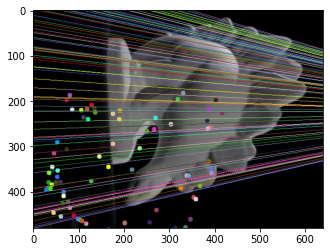

In [27]:
plt.imshow(img5)

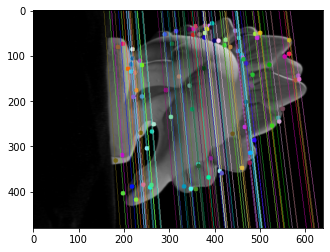

In [97]:
plt.imshow(img5)

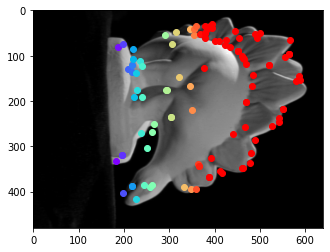

In [16]:
height0, width0 = img0.shape
plt.imshow(img0, 'gray')
color = plt.cm.rainbow(np.linspace(0,10,height0))
for idx, epipolar_line in enumerate(epipolar_lines):
    a,b,c = epipolar_line
    x = np.linspace(0,height0,100)
    y = (a/-b)*x + (c/-b)
    plt.plot(x, y, '-r', alpha=0.2, c=color[idx])
    plt.scatter(img0_pts[idx][1], img0_pts[idx][0], color=color[idx])
plt.ylim(height0,0)
plt.show()

In [16]:
pt_y, pt_x = img0_pts[0]
F @ np.array([[pt_y], [pt_x], [1]])

array([[-0.00135856],
       [-0.00126071],
       [ 0.68538413]])

In [17]:
def draw_epipolar_lines(F, img0, img1, pts0, pts1):
    height, width = img0.shape
    Pul = np.array([1, 1, 1])
    Pbl = np.array([1, width, 1])
    Pur = np.array([height, 1, 1])
    Pbr = np.array([height, width, 1])

    lL = np.cross(Pul, Pbl)
    lR = np.cross(Pur, Pbr)

    plt.figure(1)
    plt.imshow(img1)
    plt.axis('off')
    lLim, rLim = plt.ylim()
    for i in range(0, pts0.shape[0]):
        e = np.matmul(F, np.transpose(np.hstack([pts0[i, :], 1])))
        PL = np.cross(e, lL)
        PR = np.cross(e, lR)
        x = np.array([PL[0] / PL[2], PR[0] / PR[2]])
        y = np.array([PL[1] / PL[2], PR[1] / PR[2]])
        plt.plot(x, y, c='b', linewidth=0.5)

    plt.scatter(pts1[:, 0], pts1[:, 1], c='r', marker='o', s=10)
    plt.ylim(lLim, rLim)

    plt.figure(2)
    plt.imshow(img0)
    plt.axis('off')
    lLim, rLim = plt.ylim()
    for i in range(0, pts1.shape[0]):
        e = np.matmul(np.transpose(F),
                      np.transpose(np.hstack([pts1[i, :], 1])))
        PL = np.cross(e, lL)
        PR = np.cross(e, lR)
        x = np.array([PL[0] / PL[2], PR[0] / PR[2]])
        y = np.array([PL[1] / PL[2], PR[1] / PR[2]])
        plt.plot(x, y, c='b', linewidth=0.5)

    plt.scatter(pts0[:, 0], pts0[:, 1], c='r', marker='o', s=10)
    plt.ylim(lLim, rLim)
    plt.show()

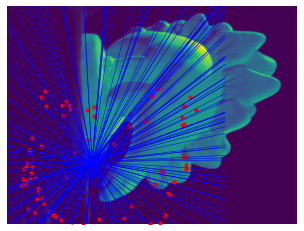

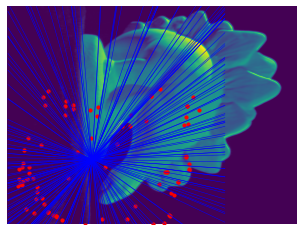

In [20]:
draw_epipolar_lines(F, img0, img1, img0_pts, img1_pts)

In [ ]:
def Ferror(F,pts1,pts2):  # pts are Nx3 array of homogenous coordinates.  
    # how well F satisfies the equation pt1 * F * pt2 == 0
    vals = pts1.dot(F).dot(pts2.T)
    err = np.abs(vals)
    return np.mean(err)